In [1]:
import pandas as pd
import modules.analysis as analysis
import modules.utils as utils

## Create metric CSV

In [13]:
df = analysis.eval_metrics('2022102313544325', out_path='analysis/benchmark/', min_months=24)

experiments/2022102313544325_15
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_7
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_19
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_3
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_17
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_22
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_26
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_18
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_28
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_13
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_8
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_27
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_11
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_0
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_12
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_21
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_29
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_2
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_6
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_10
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_5
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_4
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_20
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_23
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_24
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_25
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_14
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_1
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_9
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

experiments/2022102313544325_16
----
(18999, 2)
(18573, 2)


/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Calculates trend on site level from linear regression
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:273: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Ca

## Plot benchmark charts

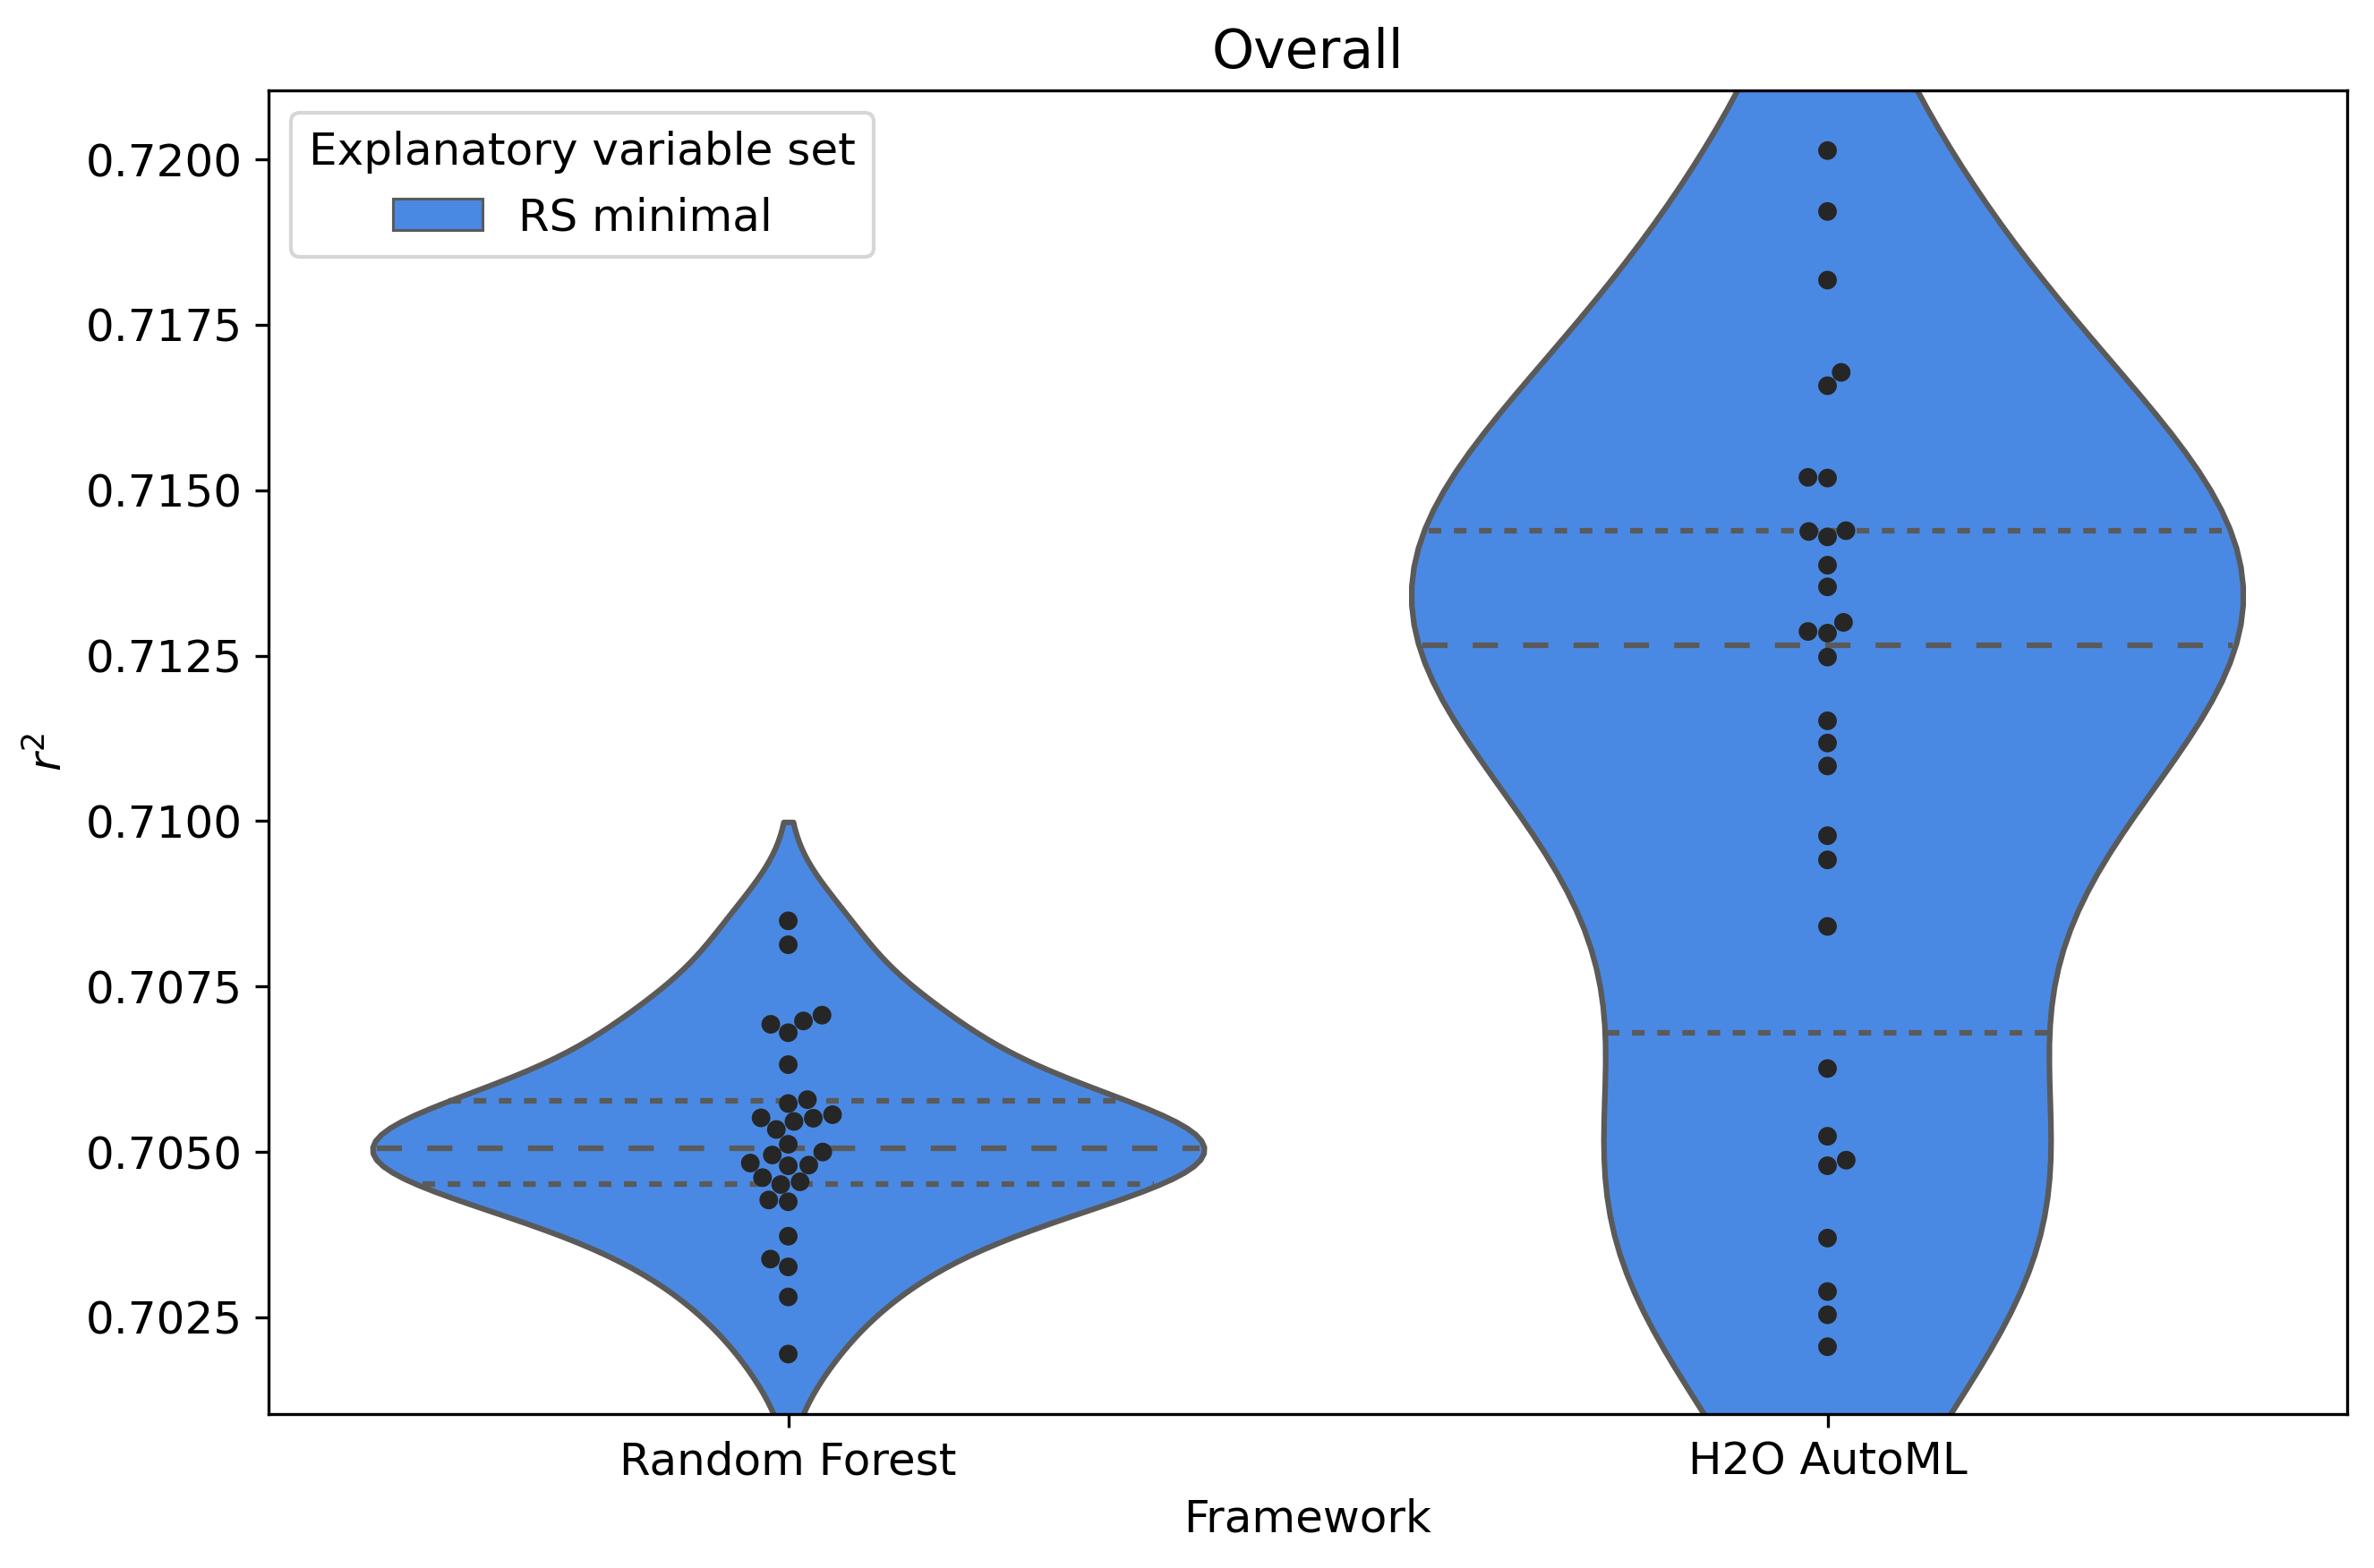

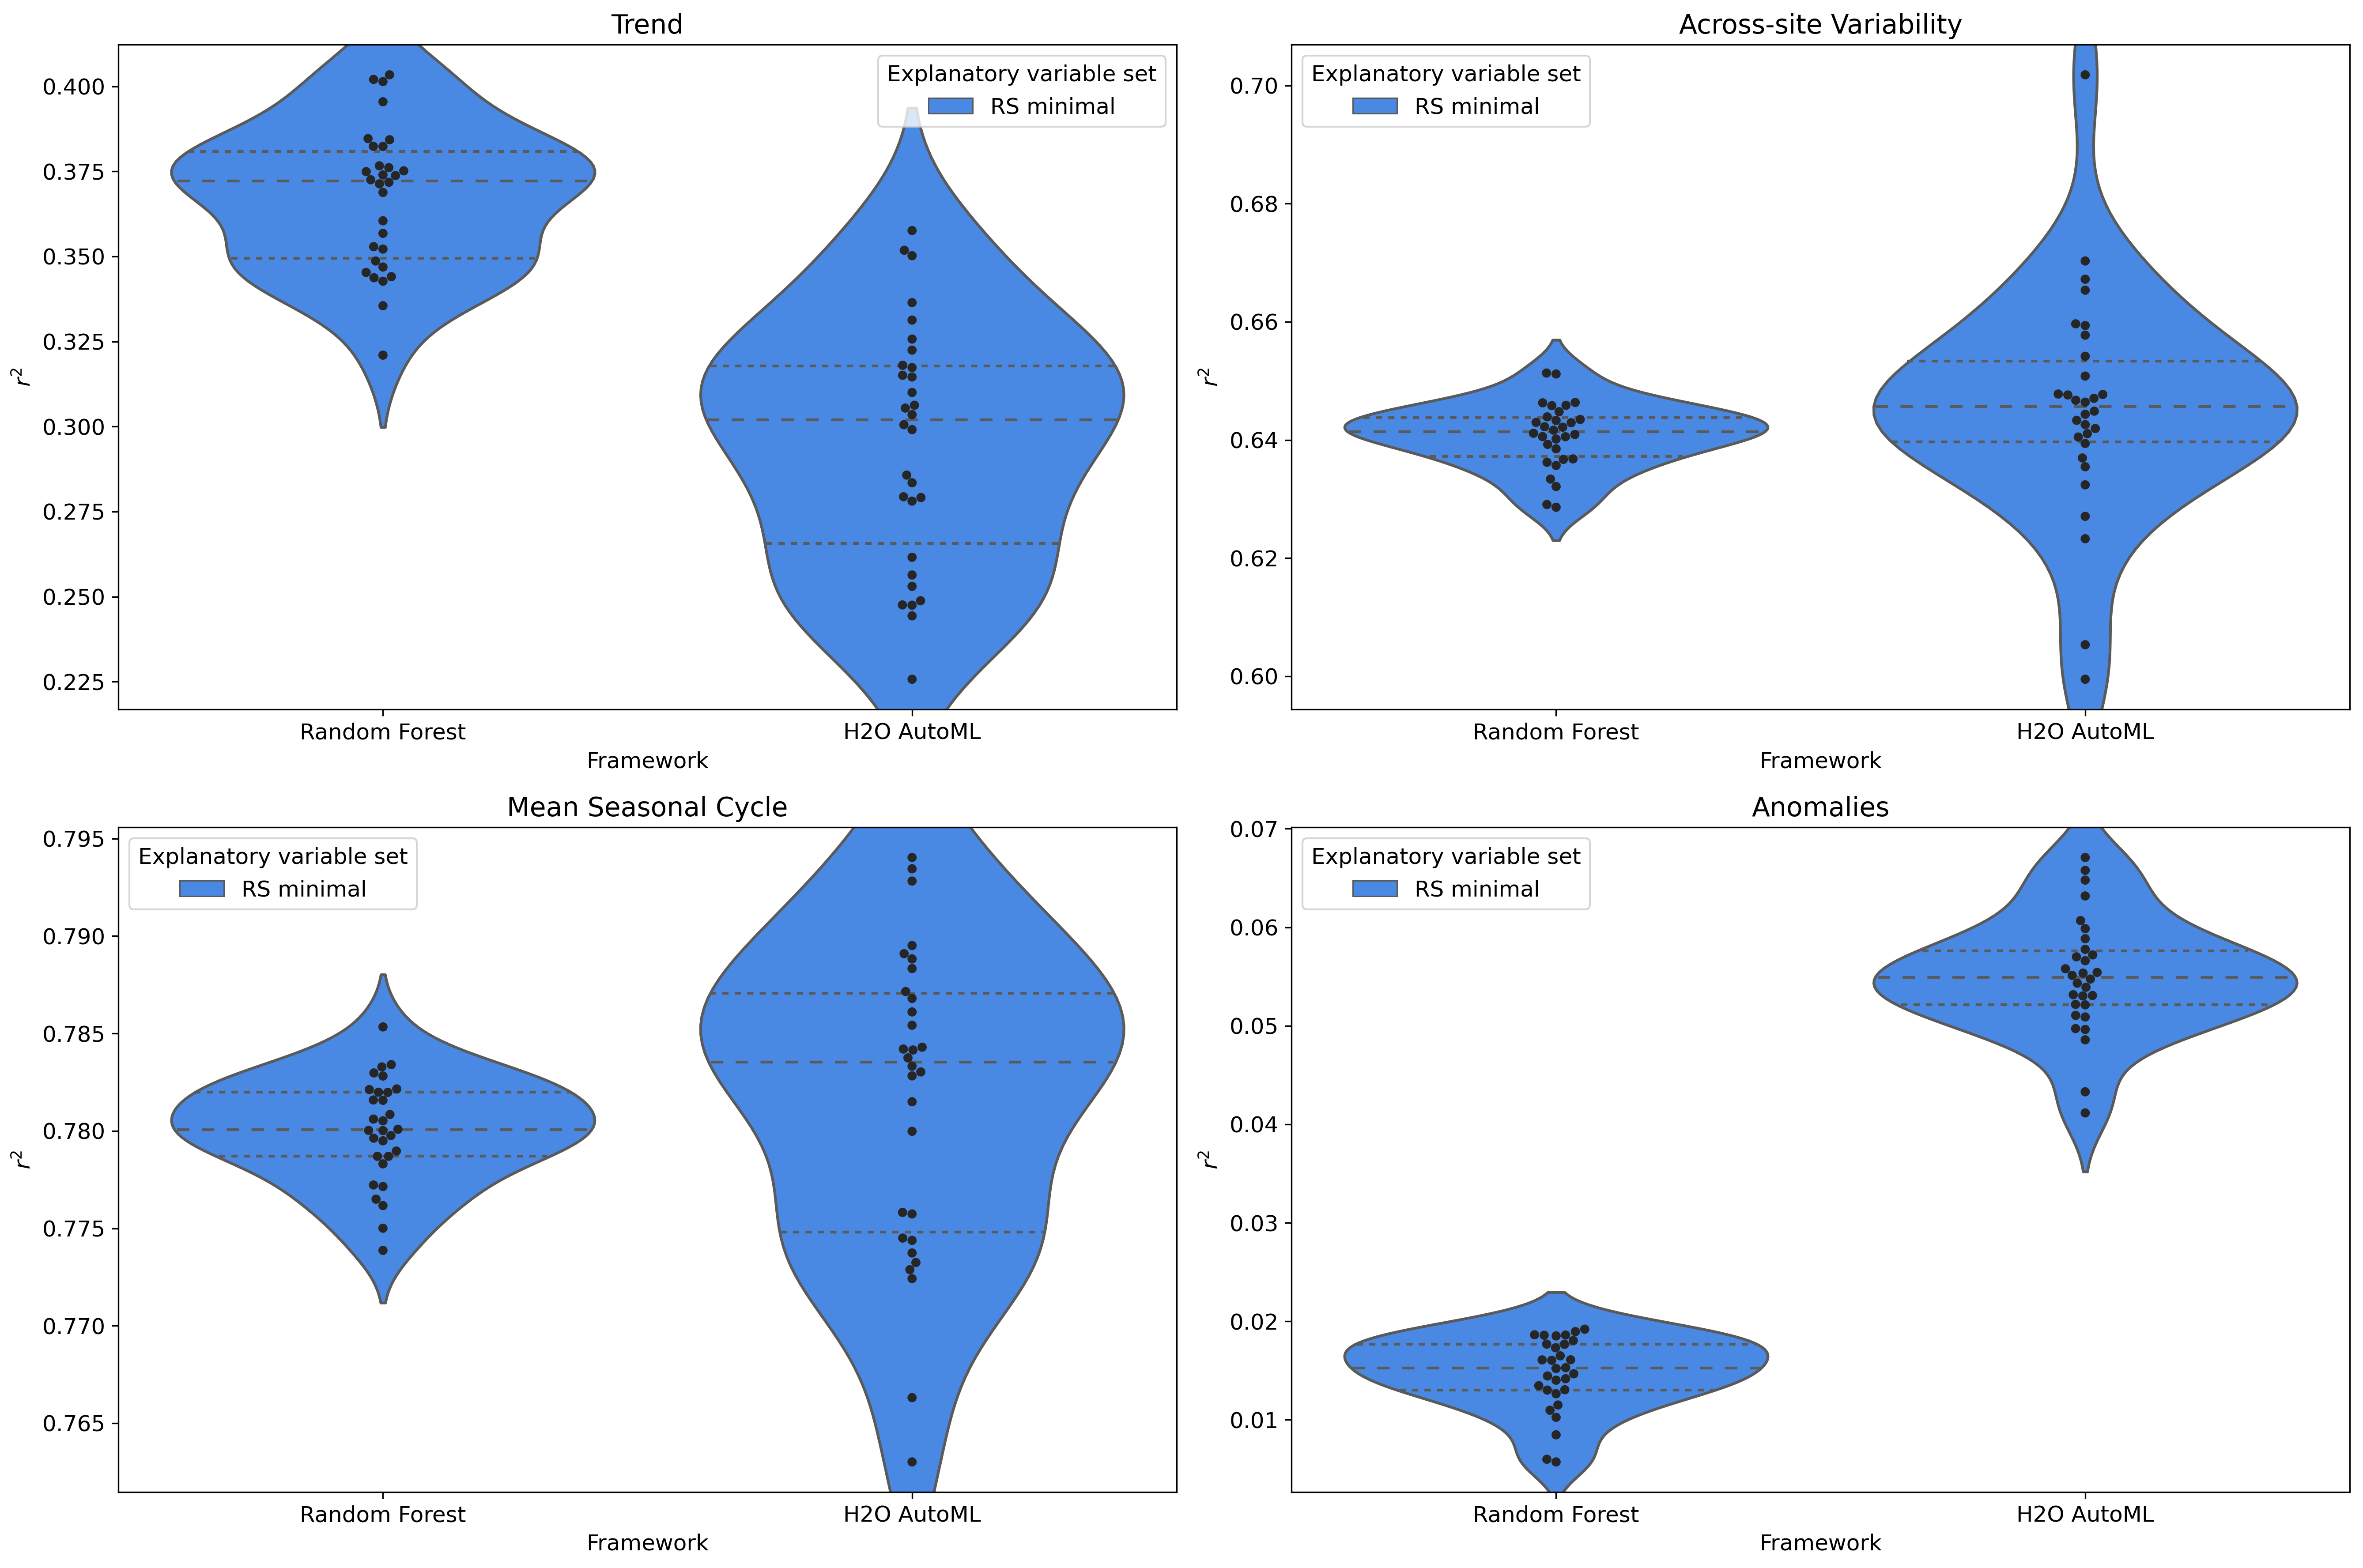

In [14]:
exp_ids = [2022102313544246, 2022102313544325]
var_sets = ['RS minimal', 'RS minimal']
frameworks = ['Random Forest', 'H2O AutoML']

frames =[]
for idx, exp_id in enumerate(exp_ids):
    df = pd.read_csv('analysis/benchmark/' + str(exp_id) + '/metrics.csv')
    df['Explanatory variable set'] = var_sets[idx]
    df['Framework'] = frameworks[idx]
    frames.append(df)
    
df = pd.concat(frames)
analysis.plt_model_comparison(df, 'analysis/benchmark/', 'Explanatory variable set', 'Framework', 'r2_overall')

## Plot LC analysis

In [28]:
sites = pd.read_csv('data/ec/sites_meta_v1.csv', index_col=0)
lc_metrics = analysis.eval_lc('2022102313544310', 'experiments/', sites, out_path='analysis/benchmark/', min_months=24)

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.groupby(['SITE_ID']).apply(lr_model)
/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/analysis.py:313: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = ts.g

In [3]:
lc_metrics = pd.read_csv('analysis/benchmark/2022102313544310/metrics_lc.csv', index_col='SITE_ID')

In [7]:
lc_metrics

,IGBP,exp_id,r2_overall,r2_msc,r2_anomalies
SITE_ID,,,,,
AT-Neu,GRA,2022102313544310_2,0.505505,0.570066,0.092960
AU-ASM,SAV,2022102313544310_2,0.665400,0.657443,0.571652
AU-Cpr,SAV,2022102313544310_2,0.408958,0.604896,0.262378
AU-Cum,EBF,2022102313544310_2,-0.292868,-0.050935,-0.361906
AU-DaP,GRA,2022102313544310_2,0.720295,0.773902,0.317511
...,...,...,...,...,...
US-WCr,DBF,2022102313544310_0,0.887715,0.914641,0.353506
US-WPT,WET,2022102313544310_0,0.748463,0.786889,-0.070619
US-Whs,SH,2022102313544310_0,0.299858,0.133757,0.533541


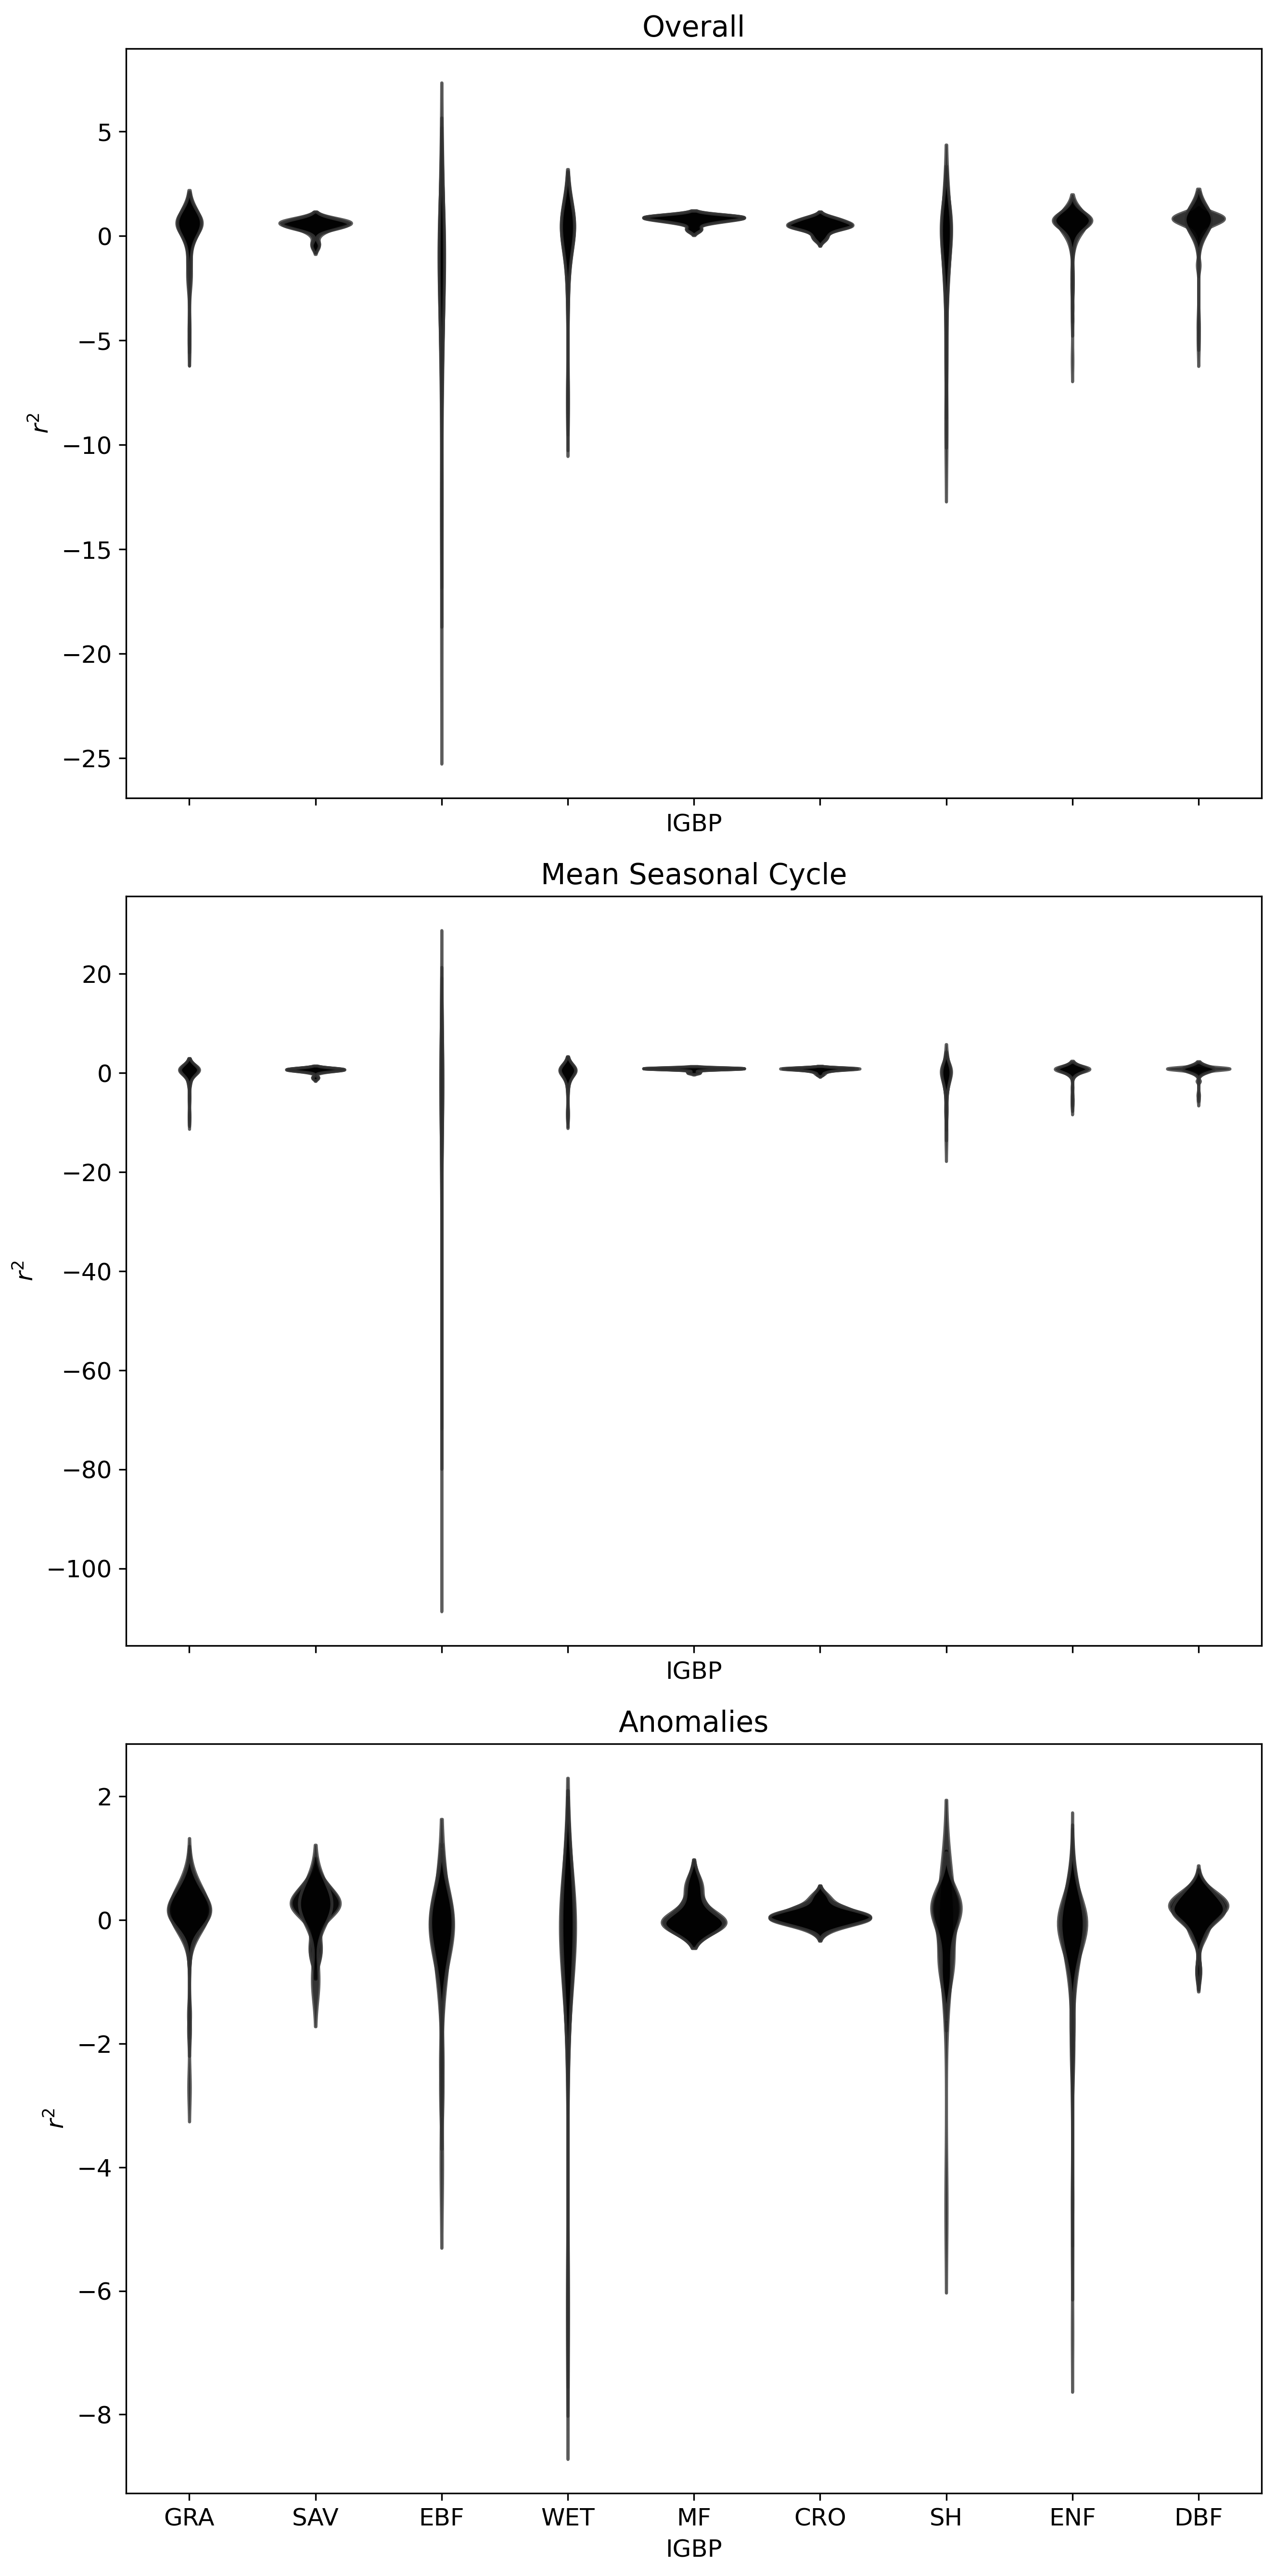

In [56]:
analysis.plt_lc_comparison(lc_metrics, 'analysis/benchmark', 'IGBP', 'exp_id')

In [55]:
from importlib import reload
reload(analysis)
reload(utils)

<module 'modules.utils' from '/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/utils.py'>

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

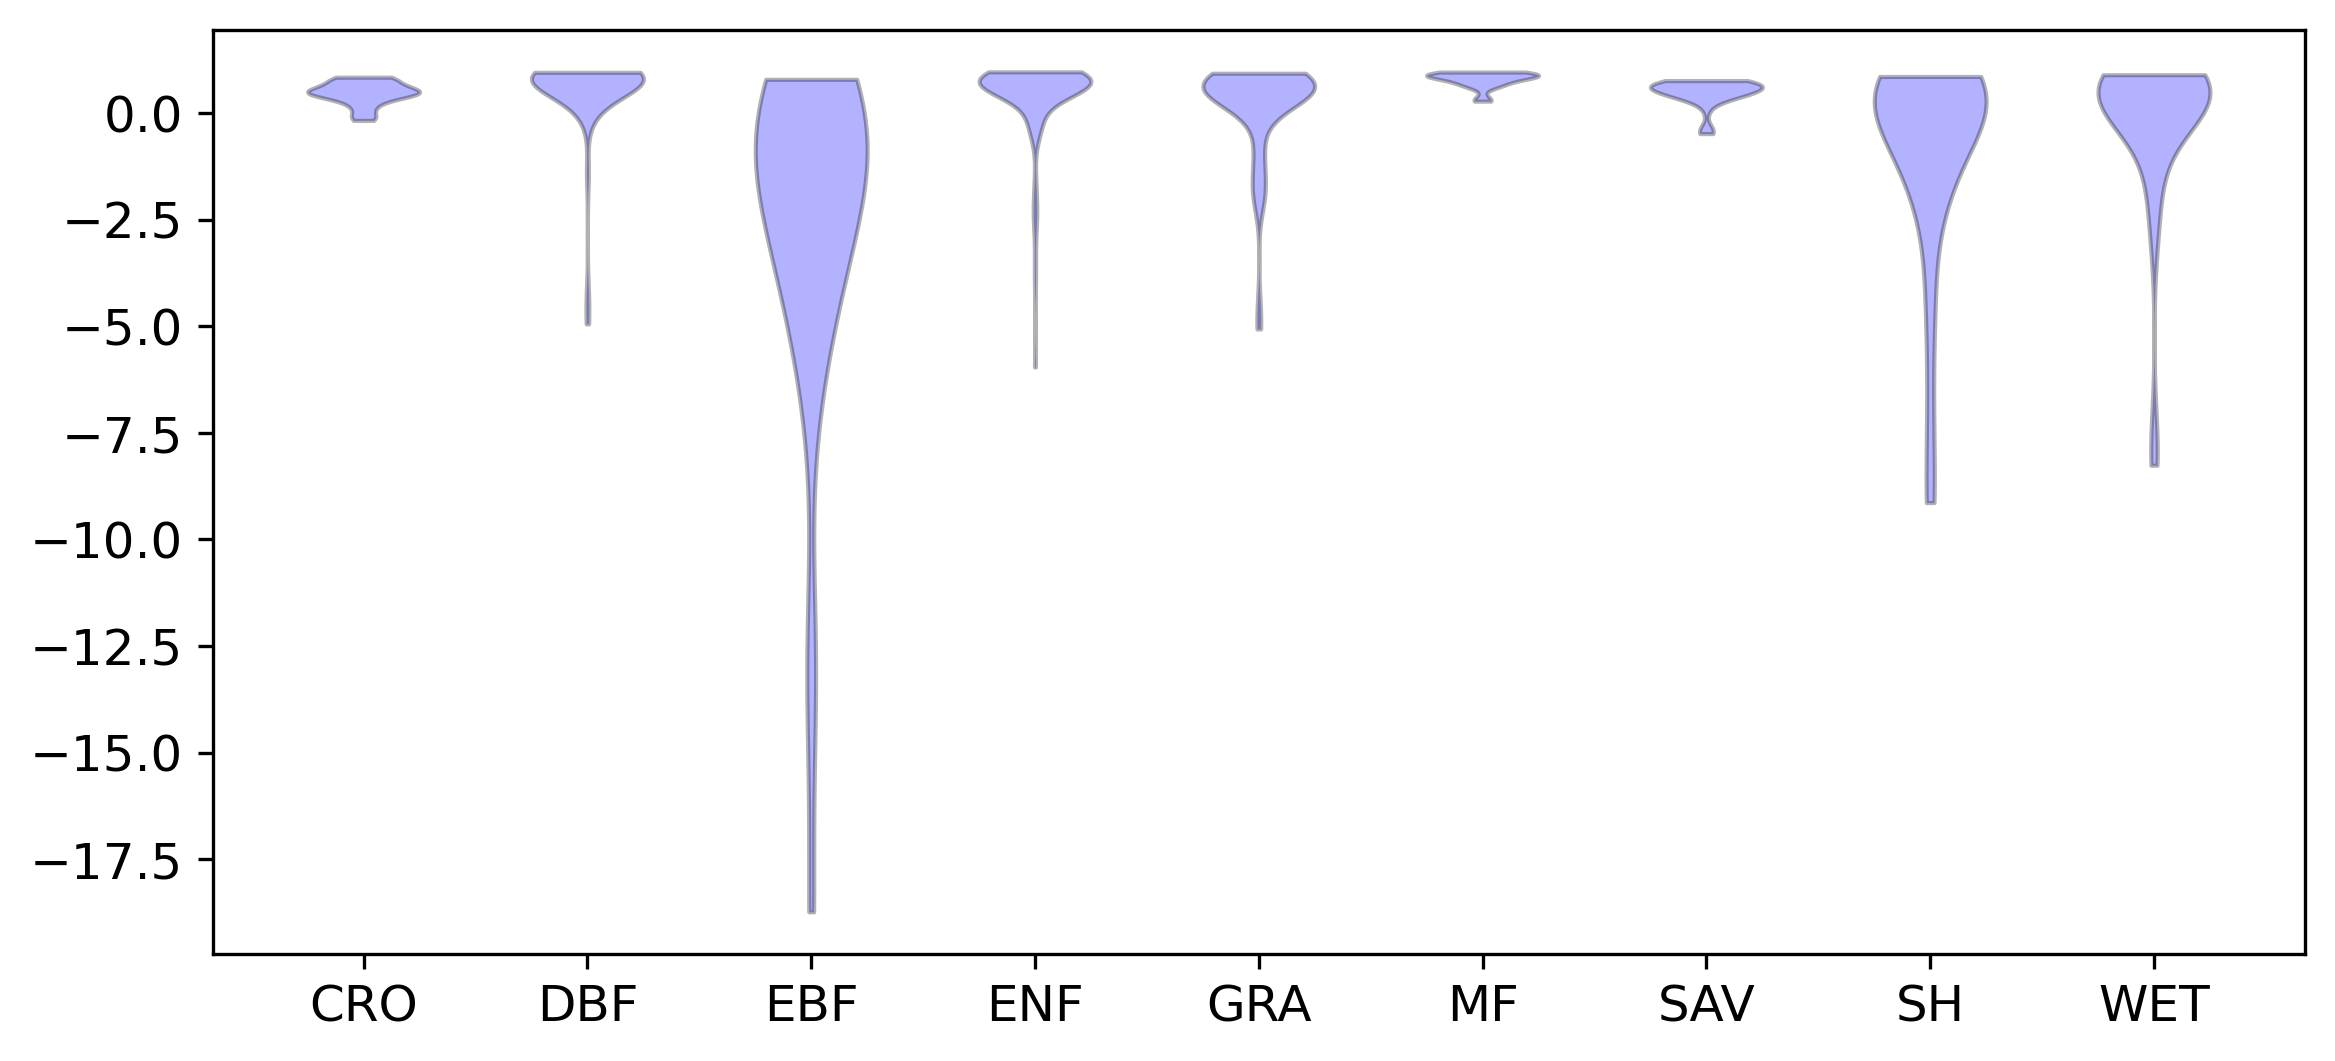

In [25]:
lc_grouped = lc_metrics.groupby('IGBP')['r2_overall'].apply(list)
fig, ax = plt.subplots(figsize=(9, 4))
parts = ax.violinplot(lc_metrics.groupby('IGBP')['r2_overall'].apply(list).to_list(), bw_method='scott', showmeans=False, showmedians=False, showextrema=False)
labels = lc_grouped.index.values
ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
for pc in parts['bodies']:
    pc.set_facecolor((0, 0, 1, 0))
    pc.set_edgecolor('black')
    #pc.set_alpha(1)

9
['_A', '_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiaseds', '_axes', '_bcast_lwls', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_default_contains', '_edge_default', '_edge_is_mapped', '_edgecolors', '_face_is_mapped', '_facecolors', '_factor', '_fully_clipped_to_axes', '_get_default_antialiased', '_get_default_edgecolor', '_get_default_facecolor', '_get_default_linewidth', '_gid', '_hatch', '_hatch_color', '_id_norm', '_in_layout', '_internal_update', '_joinstyle', '_label', '_linestyles', '_linewidths', '_mapped_colors', '_mouseover', '_norm', '_offset_transform'

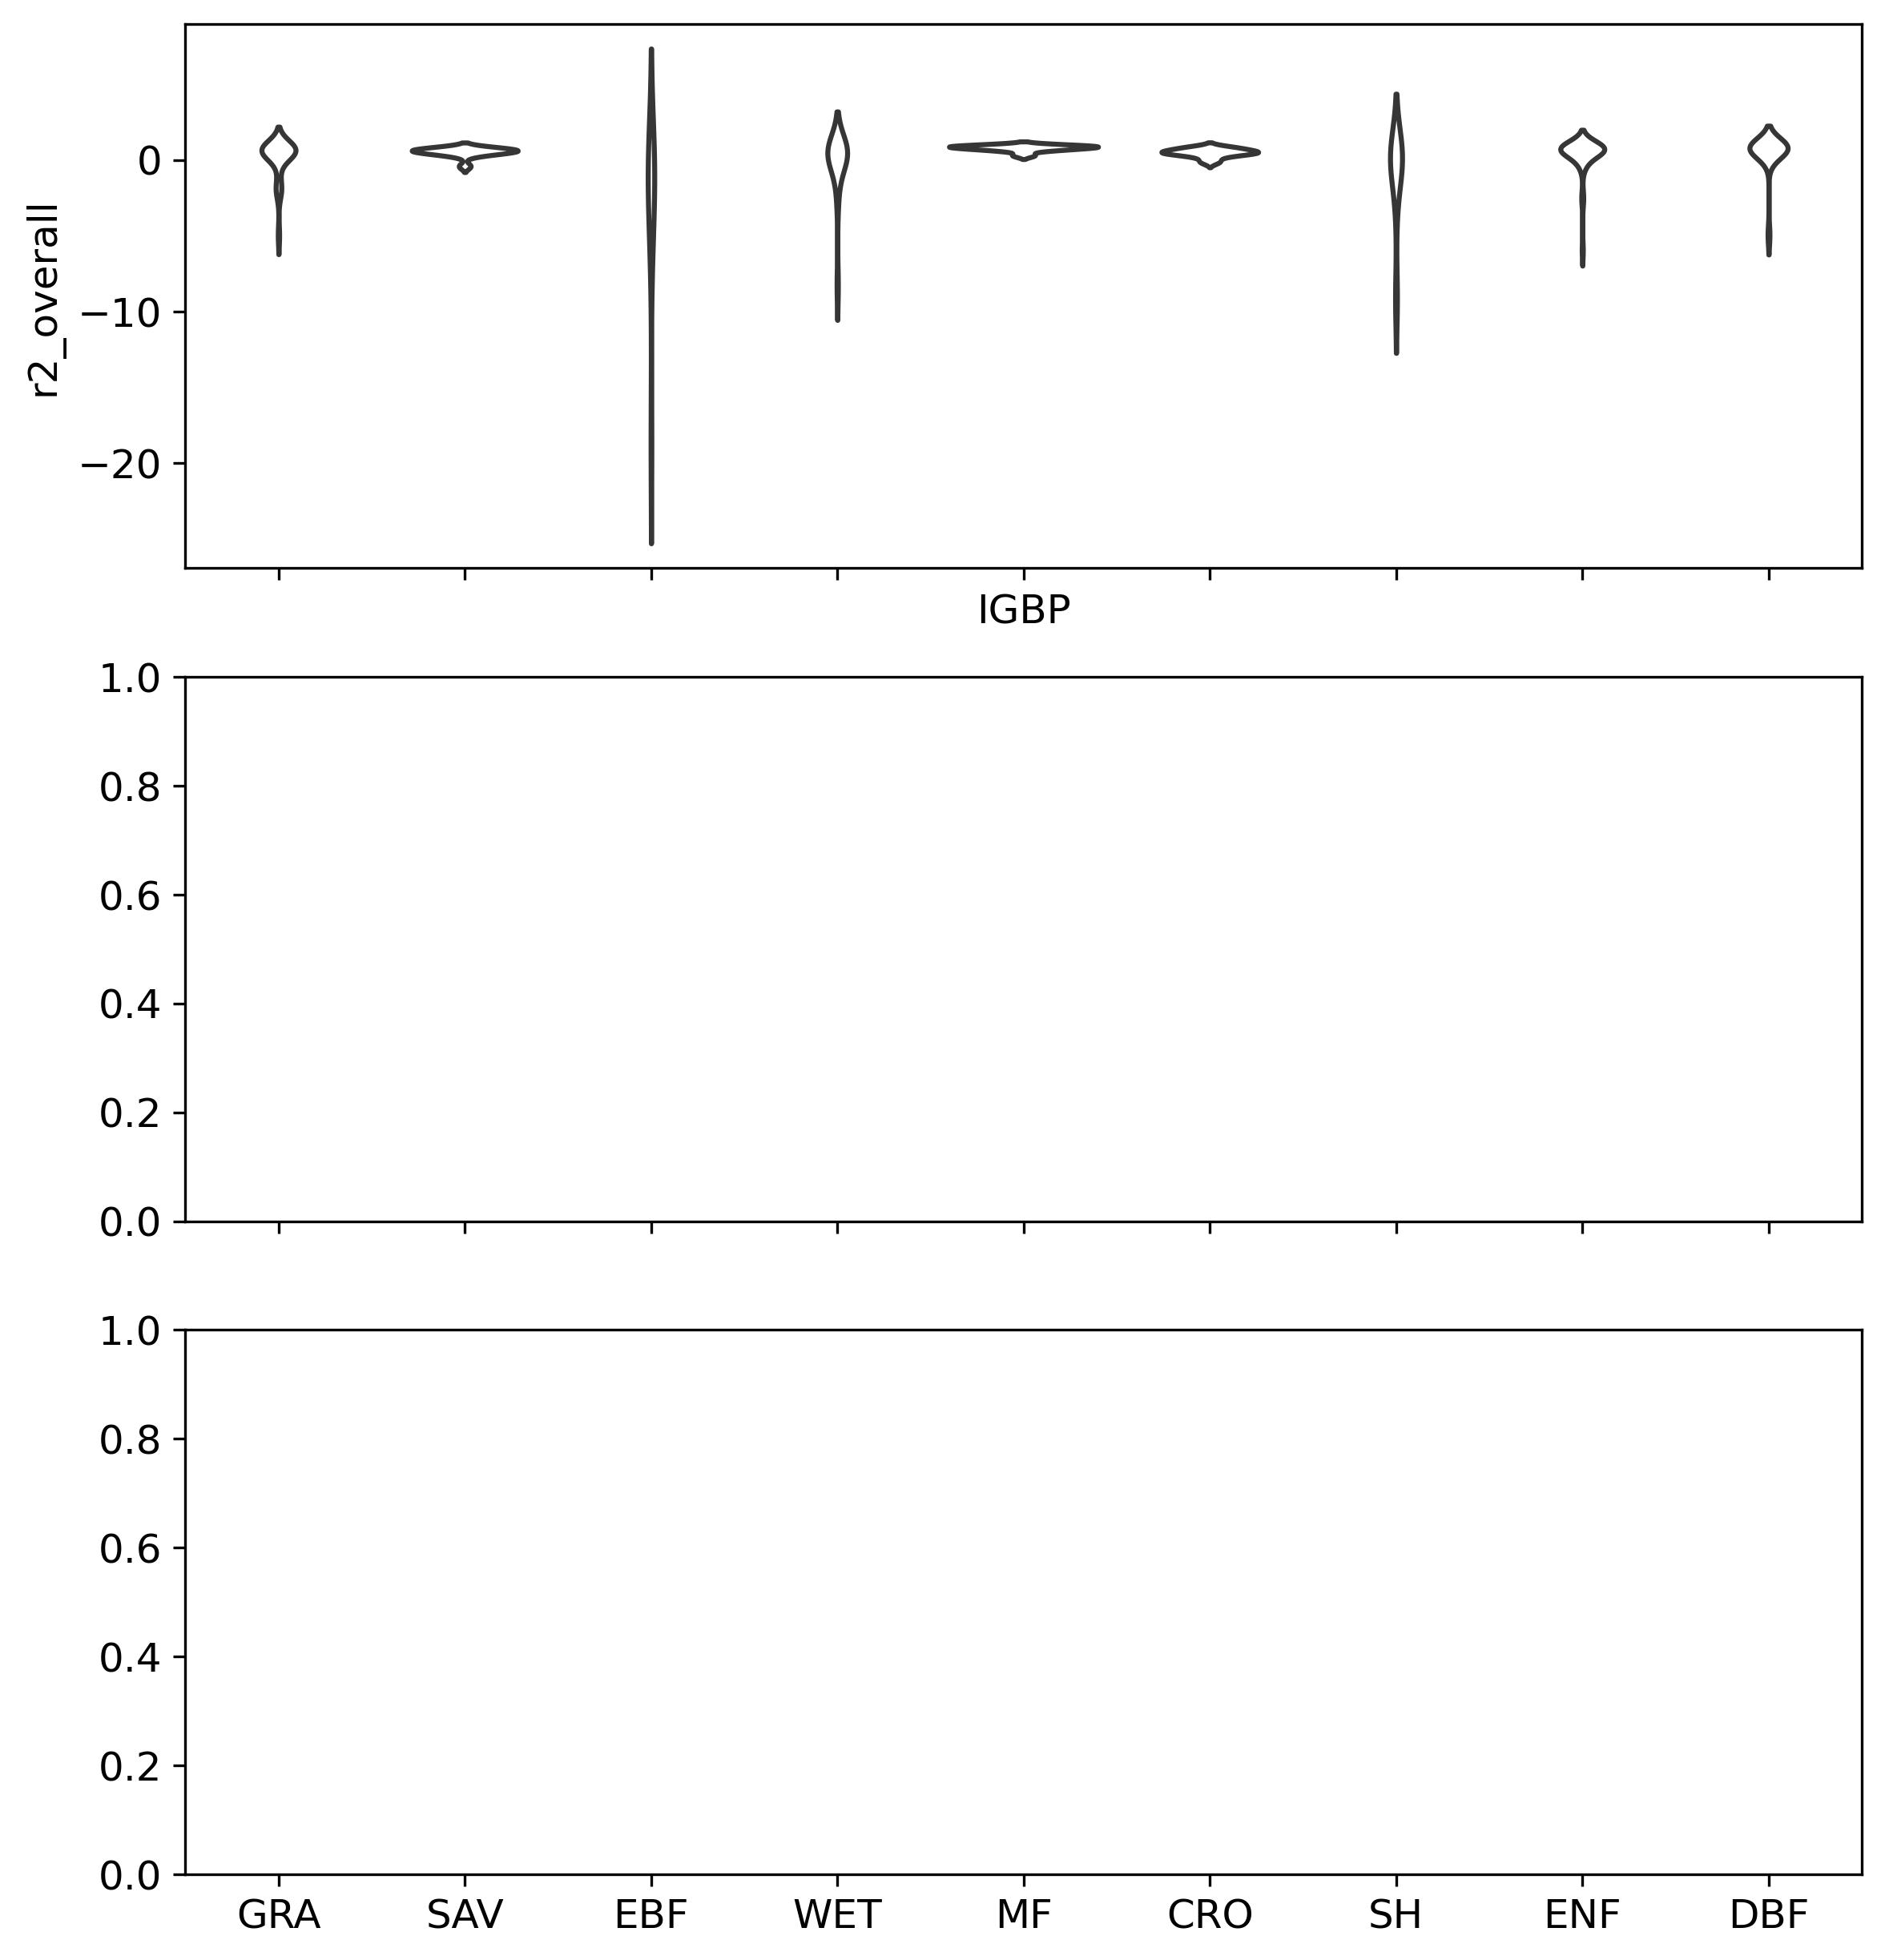

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(9, 10), sharex=True)
for exp_id in lc_metrics['exp_id'].unique():
        df = lc_metrics[lc_metrics['exp_id'] == exp_id]
        sns.violinplot(x='IGBP', y='r2_overall', data=df, ax=ax[0], inner='box')
        print(len(ax[0].collections[::2]))
        for col in ax[0].collections[::2]:
            col.set_facecolor((0, 0, 0, 0))
        
        for cc in ax[0].collections[1::2]:
            cc.set_alpha(0)
            
        for cd in ax[0].lines:
            cd.set_alpha(0)
            
        print(dir(col))
            
        break